In [1]:
%reset -f
import os, pandas as pd, numpy as np, tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
USE_GPU = False

if not USE_GPU:
    try:
        # Disable all GPUSs
        tf.config.set_visible_devices([], 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        print("failed to disable gpu")
        # Invalid device or cannot modify virtual devices once initialized.
        pass
print(tf.config.get_visible_devices())
from modules.param_wgan_gp import load_model

import ROOT
from ROOT import TCanvas, TLatex, TH1F, TH2F
ROOT.gStyle.SetOptStat(0)
lat = TLatex()
lat.SetTextSize(0.04)
hhs_1d = {}

tf.random.set_seed(42)

mname, epoch = "CM_small_dLNdKR", 1
gan = load_model(f"models/{mname}/model_params.json", 
                    f"models/{mname}/epoch{epoch}/generator_weights.h5", 
                    f"models/{mname}/epoch{epoch}/discriminator_weights.h5")
col_ns = list(gan.pd['feat_names'])
print(col_ns)
col_fns = ['Q^{2} [GeV^{2}]', 'x_{B}', 'y', '-t [GeV^{2}]', '#varphi_{HADRON} [deg]']

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Welcome to JupyROOT 6.24/02
['Q2', 'Xbj', 'y', 't', 'phih']


In [2]:
mceg_df = pd.DataFrame(dict(zip(list(gan.pd['feat_names']), np.load("data/raw/X.npy")[:1000000].T)))
mceg_df.phih = mceg_df.phih - 360*(mceg_df.phih>180)
gan_df = gan.generate(n_samples=len(mceg_df), batch_size=1000000, verbose=False, gpu=USE_GPU)
mceg_rdf = ROOT.RDF.MakeNumpyDataFrame(dict(zip(mceg_df.columns, mceg_df.values.T)))
gan_rdf = ROOT.RDF.MakeNumpyDataFrame(dict(zip(gan_df.columns, gan_df.values.T)))

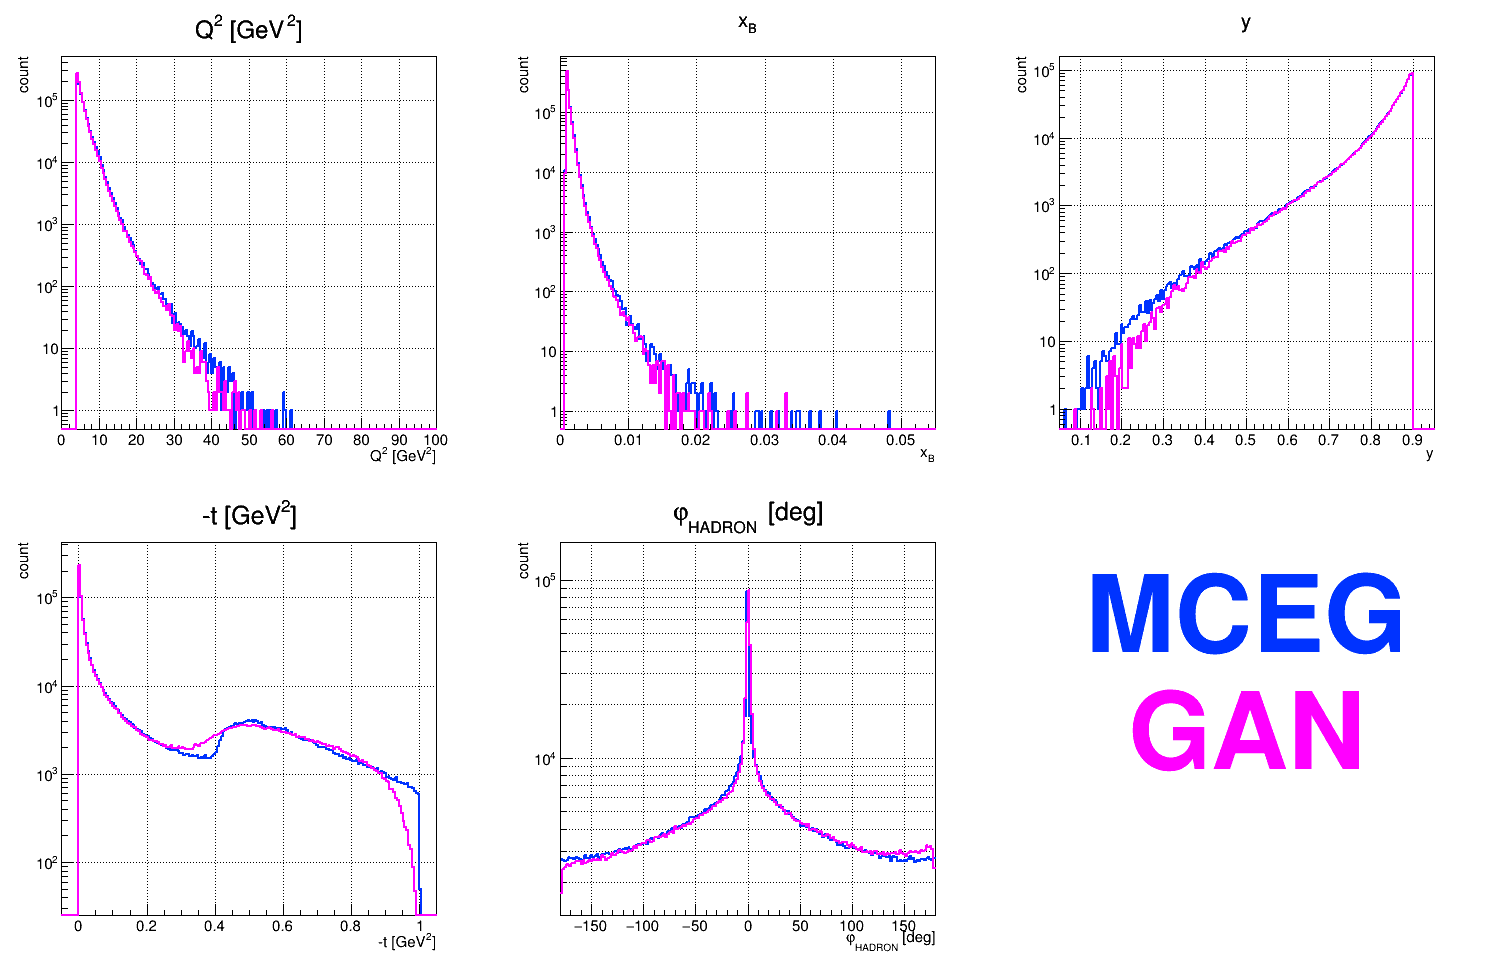

In [3]:
c1 = TCanvas("c1", "c1", 1500, 1000); c1.Divide(3,2); c1.Draw()
# ROOT.gStyle.SetLabelSize(0.045)

for rdf, rf in zip([mceg_rdf, gan_rdf], ["MCEG", "GAN"]):
    for i, (col, (lb, ub)) in enumerate(zip(col_ns, [(0, 100), (0, .055), (.05, .95), (-0.05, 1.05), (-180, 180)])):
    # for i, (col, (lb, ub)) in enumerate(zip(col_names, [(0, 100), (16, 72), (0, .055), (.05, .95), (-0.05, 1.05), (-180, 180)])):
        c1.cd(i+1).SetGrid()
        c1.cd(i+1).SetLogy()
        # c1.cd(i+1).SetMargin(0.07,0.07,0.07,0.07)
        hhs_1d[f"{col}_{rf}"] = rdf.Histo1D((f"h1d_{col}_{rf.lower()}", f"{col_fns[i]};{col_fns[i]};count", 200, lb, ub), col)
        hhs_1d[f"{col}_{rf}"].Draw("SAME")
        hhs_1d[f"{col}_{rf}"].SetLineColor(ROOT.kAzure if rf == "MCEG" else ROOT.kMagenta)
        hhs_1d[f"{col}_{rf}"].SetLineWidth(2)

c1.cd(6)
lat.SetTextSize(0.25)
lat.SetTextAlign(22)
lat.SetTextColorAlpha(ROOT.kAzure, 1)
lat.DrawLatexNDC(.5,.75,"MCEG")
lat.SetTextColorAlpha(ROOT.kMagenta, 1)
lat.DrawLatexNDC(.5,.5,"GAN")

# c1.Print("test.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


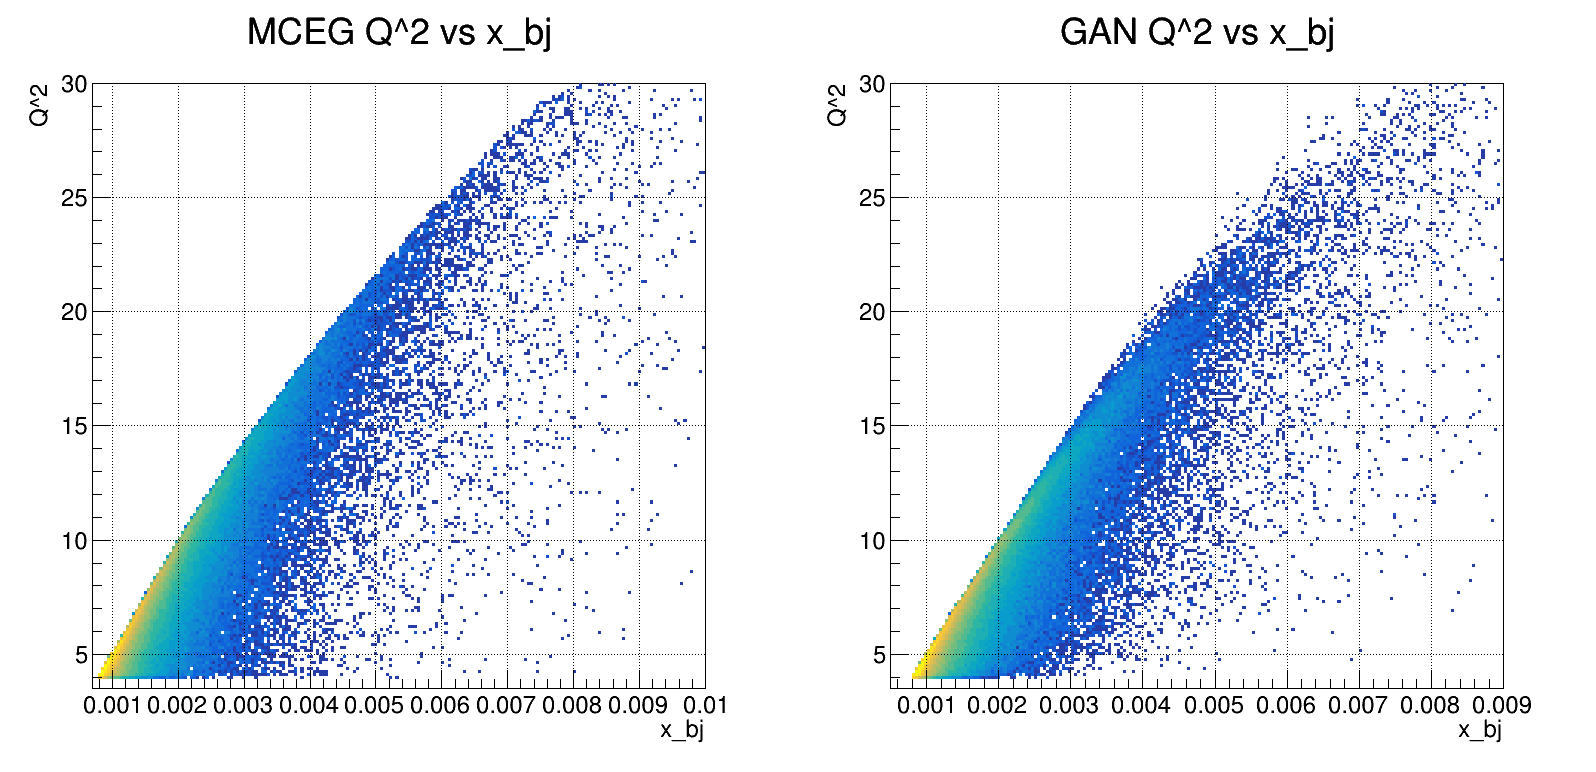

In [4]:
c1 = TCanvas("c1", "c1", 1600, 800); c1.Divide(2,1); c1.Draw()

hq2xb_mceg = mceg_rdf.Histo2D(("h2d_q2xb_mceg", "MCEG Q^2 vs x_bj;x_bj;Q^2", 200, 0.0007, 0.01, 200, 3.5, 30), "Xbj", "Q2")
hq2xb_gan  =  gan_rdf.Histo2D(("h2d_q2xb_gan",  "GAN Q^2 vs x_bj;x_bj;Q^2",  200, 0.0005, 0.009, 200, 3.5, 30), "Xbj", "Q2")

c1.cd(1).SetGrid()
c1.cd(1).SetLogz()

hq2xb_mceg.Draw("col")

c1.cd(2).SetGrid()
c1.cd(2).SetLogz()

hq2xb_gan.Draw("col")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


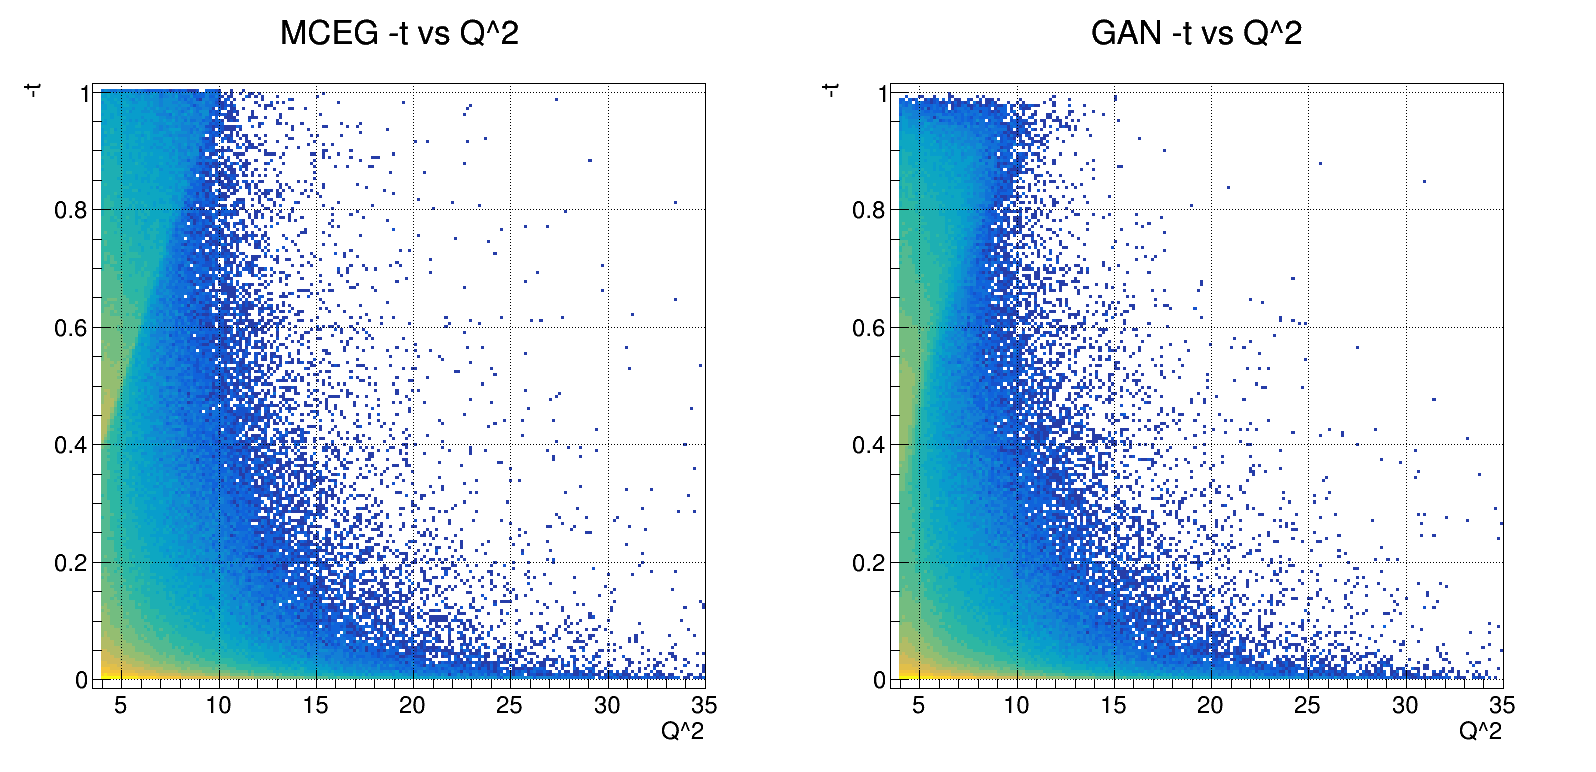

In [5]:
c1 = TCanvas("c1", "c1", 1600, 800); c1.Divide(2,1); c1.Draw()

htq2_mceg = mceg_rdf.Histo2D(("h2d_tq2_mceg", "MCEG -t vs Q^2;Q^2;-t", 200, 3.5, 35, 200, -.015, 1.015), "Q2", "t")
htq2_gan  =  gan_rdf.Histo2D(("h2d_tq2_gan",  "GAN -t vs Q^2;Q^2;-t",  200, 3.5, 35, 200, -.015, 1.015), "Q2", "t")

c1.cd(1).SetGrid()
c1.cd(1).SetLogz()

htq2_mceg.Draw("col")

c1.cd(2).SetGrid()
c1.cd(2).SetLogz()

htq2_gan.Draw("col")
